In [83]:
import random
import networkx as nx
import matplotlib.pyplot as plt

In [96]:
class Architecture:
    def __init__(self):
        self.c_capacity, self.s_capacity = 100, 10
        self.weights = [0.0125, 0.0010, 0.0200, 0.5000] # REVIEW
        self.lifetime = {0: 2, 1: 3, 2: 4, 3: 10}   # REVIEW
        self.max_actions = 10
        self.num_s = 2
        self.num_c = 6
        self.max_monitorization = (self.num_c + self.num_c)*6
        self.max_market = self.num_c * 2

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.data = {}
        self.devices = {}
        self.latencies = {}


        for j in (range(len(self.weights))):
            self.data[j] = {}
            for i in range(self.num_s+self.num_c):
                self.data[j][i] = 0
                self.devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.latencies[i] = {}

        randomized = list(self.devices.keys())
        random.shuffle(randomized)
        bound = round(len(self.devices)/4)
        self.clusters = {
            0: randomized[:bound],
            1: randomized[bound:bound*2],
            2: randomized[bound*2:bound*3],
            3: randomized[bound*3:]
        }

        self.visualization()

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)
        print(deads)
        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= 0.2:
                self.space_flag = i
        return load

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.num_s]
        ss = keys[self.num_s:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.num_s)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.num_s)+len(ss)%self.num_s):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        plt.title("Architecture:")
        plt.axis('off')
        plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

    # def compute_total_latency(self):
    #     total_latency = 0
    #     for i in range(len(self.action_type)):
    #         total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device_dev[i]].values())])
    #     return total_latency

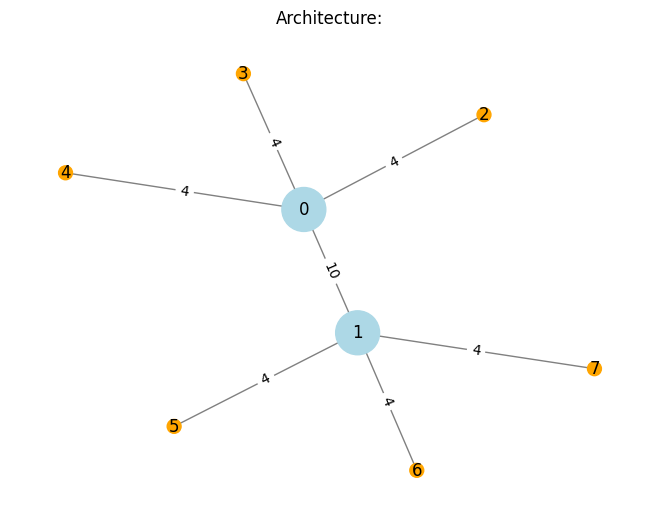

[]
{0: {0: 0, 2: 4, 3: 4, 4: 4, 1: 10, 5: 14, 6: 14, 7: 14}, 1: {1: 0, 5: 4, 6: 4, 7: 4, 0: 10, 2: 14, 3: 14, 4: 14}, 2: {2: 0, 0: 4, 3: 8, 4: 8, 1: 14, 5: 18, 6: 18, 7: 18}, 3: {3: 0, 0: 4, 2: 8, 4: 8, 1: 14, 5: 18, 6: 18, 7: 18}, 4: {4: 0, 0: 4, 2: 8, 3: 8, 1: 14, 5: 18, 6: 18, 7: 18}, 5: {5: 0, 1: 4, 6: 8, 7: 8, 0: 14, 2: 18, 3: 18, 4: 18}, 6: {6: 0, 1: 4, 5: 8, 7: 8, 0: 14, 2: 18, 3: 18, 4: 18}, 7: {7: 0, 1: 4, 5: 8, 6: 8, 0: 14, 2: 18, 3: 18, 4: 18}}


In [99]:
architecture = Architecture()
architecture.update(3,1)
architecture.heart_beat()
# print(architecture.devices)
# print(architecture.data)
# architecture.free_space()
print(architecture.latencies)